In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets.utils import TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
#stats = ((0.4791, 0.4533, 0.4042), (0.2603, 0.2529, 0.2662))
#tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
stats = ((0.4818, 0.4549, 0.4063), (0.2612, 0.2545, 0.2673))
tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [3]:
high_res = './face_dataset/high_res'
low_res = './face_dataset/low_res'

In [4]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, root1,root2, transform):
        super().__init__()
        self.root1 = root1
        self.root2 = root2
        self.transform = transform
        self.x = ImageFolder(self.root1,self.transform)
        self.y = ImageFolder(self.root2,self.transform)

    def __len__(self):
        return len(ImageFolder(self.root1))

    def __getitem__(self, idx): 

        return self.x[idx][0], self.y[idx][0]

In [5]:
dataset=CustomDataset(low_res,high_res,tfms)

In [6]:
val_size = 500
train_size = len(dataset) - val_size
torch.manual_seed(43)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(59500, 500)

In [7]:
def denormalize(img_tensors):
    v=img_tensors
    v[0]=v[0] * stats[1][0] + stats[0][0]
    v[1]=v[1] * stats[1][1] + stats[0][1]
    v[2]=v[2] * stats[1][2] + stats[0][2]
    return v
def show_image(dl,dr):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(denormalize(dl).permute(1, 2, 0))
    ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(denormalize(dr).permute(1, 2, 0))
    
    f.set_figheight(18)
    f.set_figwidth(18)
    

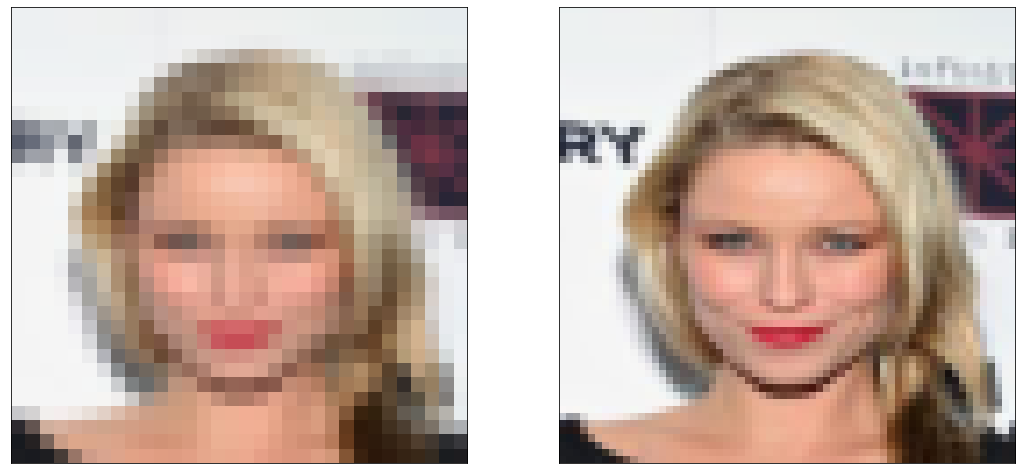

In [8]:
n=4070
show_image(train_ds[n][0],train_ds[n][1])

In [9]:
# PyTorch data loaders
batch_size = 25
train_dl = DataLoader(train_ds, batch_size, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [13]:
class UpscalingBase(nn.Module):
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.mse_loss(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.mse_loss(out, targets)   # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(0.2, inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class upscaler(UpscalingBase):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.convtrans1=nn.Sequential(nn.ConvTranspose2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(64), 
                        nn.LeakyReLU(0.2, inplace=True))             
        self.conv1 = conv_block(64, 128)
        self.conv2 = conv_block(128, 256, pool=False)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.convtrans2=nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(128), 
                        nn.LeakyReLU(0.2, inplace=True))
        
        self.conv3 = conv_block(128, 64, pool=False)
        self.conv4 = conv_block(64, 32, pool=False)
        self.res2 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        
        self.classifier = nn.Sequential(conv_block(32, 16, pool=True),
                                        nn.LeakyReLU(0.2, inplace=True),
                                        nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
                                        nn.Tanh())
        
    def forward(self, xb):
        out = self.convtrans1(xb)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.convtrans2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [15]:
model = to_device(upscaler(3, 3), device)
model

upscaler(
  (convtrans1): Sequential(
    (0): ConvTranspose2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Lea

In [16]:
from tqdm.notebook import tqdm

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def predict_image(img1,img2, model):
    # Convert to a batch of 1
    xb = to_device(img1.unsqueeze(0),device)
    yb = model(xb)
    yb=torch.squeeze(yb)
    print(yb.detach().cpu().shape)
    show_image(img1,yb.detach().cpu())
    
   

In [19]:
%%time
history = [evaluate(model, val_dl)]
history

Wall time: 5.29 s


[{'val_loss': 1.293055534362793}]

torch.Size([3, 64, 64])


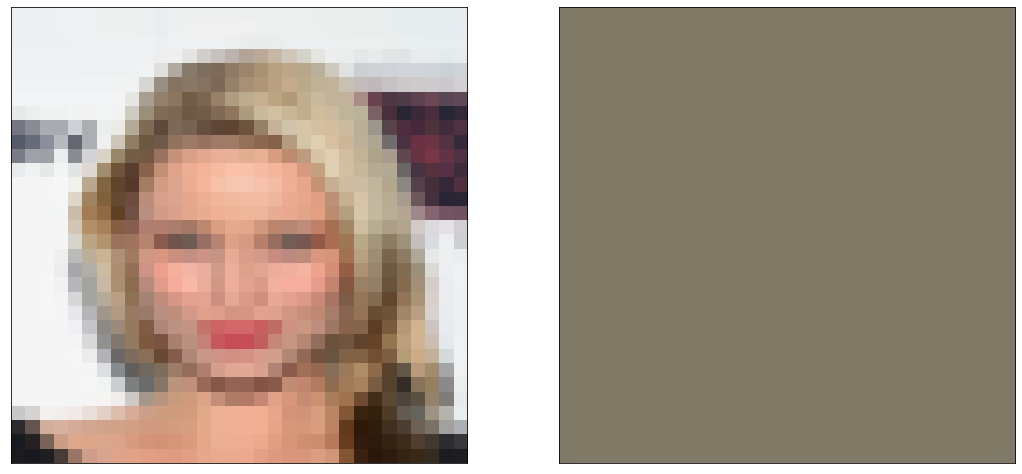

In [20]:
n=4070
predict_image(train_ds[n][0],train_ds[n][1],model)

In [21]:
epochs = 2
max_lr = 0.0001
grad_clip = 0.01
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00008, train_loss: 0.2006, val_loss: 0.1651


  0%|          | 0/2380 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00000, train_loss: 0.1591, val_loss: 0.1640
Wall time: 54min 49s


In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [24]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

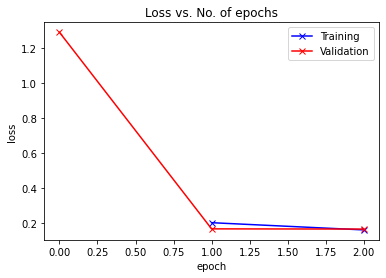

In [25]:
plot_losses(history)

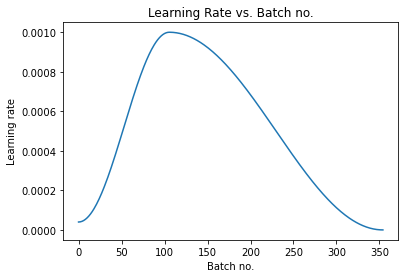

In [25]:
plot_lrs(history)

torch.Size([3, 64, 64])


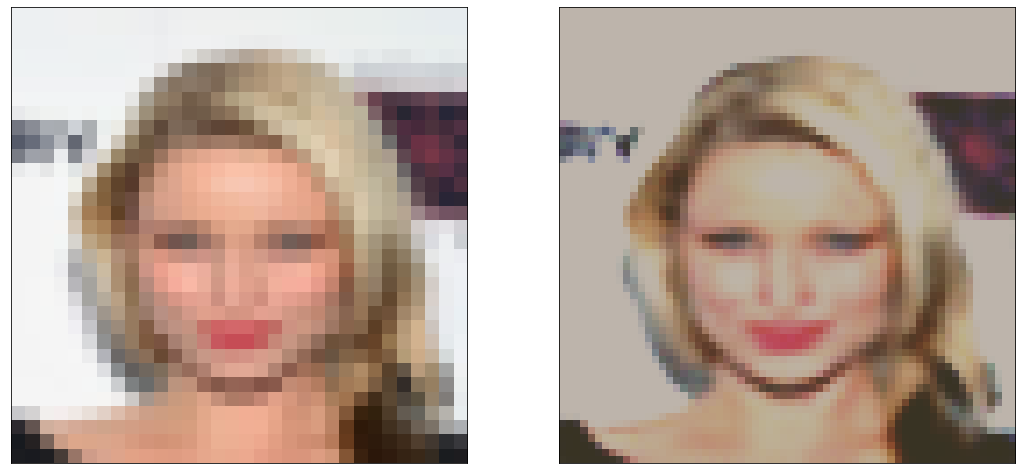

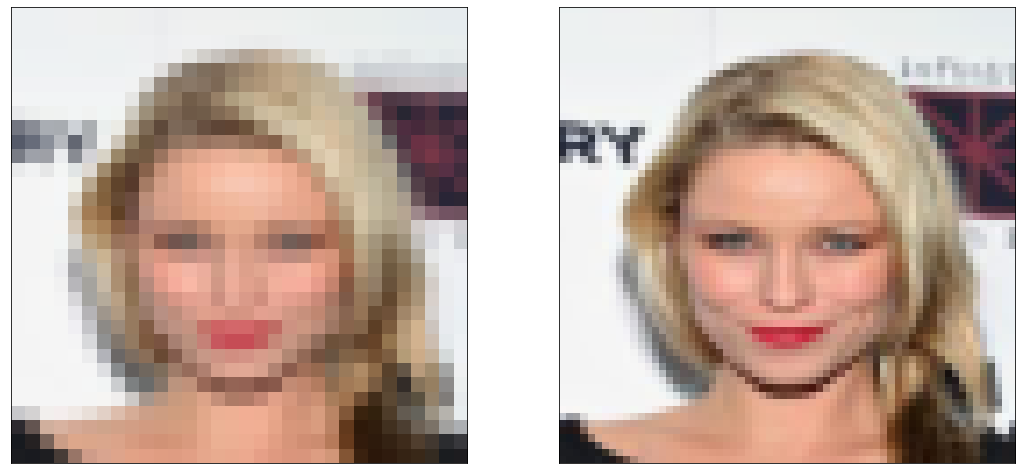

In [26]:
n=4070
img=train_ds[n]
predict_image(img[0],img[1],model)
img=train_ds[n]
show_image(img[0],img[1])

In [27]:
torch.save(model.state_dict(), 'deep_learning_upscaler.pth')

In [ ]:
model.load_state_dict(torch.load('deep_learning_upscaler.pth'))

In [28]:
img=ImageFolder('./my_image',tfms)

In [29]:
def upscale_image(image,model):
    img=to_device(torch.zeros(3,128*2,128*2),device)
    for i in range(4):
        for j in range(4):
            img1=image[:,i*32:32*(i+1),j*32:32*(j+1)]
            img1=to_device(img1.unsqueeze(0),device)
            img[:,i*64:64*(i+1),j*64:64*(j+1)]=torch.squeeze(model(img1))     
    show_image(image,img.detach().cpu())

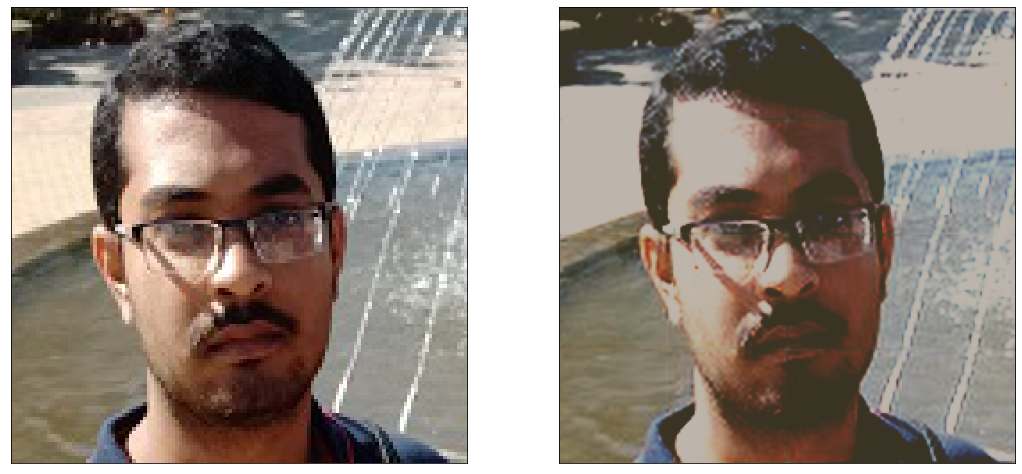

In [30]:
upscale_image(img[0][0],model)

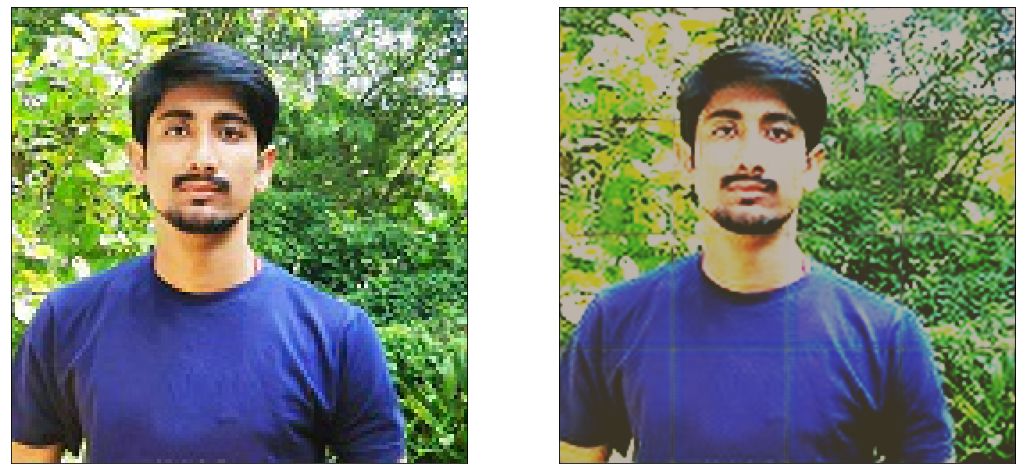

In [34]:
upscale_image(img[1][0],model)